This notebook was specifically created to test whether the oscillating trend observed when using a single diffusion coefficient between 0.5 and 0.9 mm^2/week could be related to a numerical error. To verify this, we reduced the time step from 0.01 to 0.001, and now attempt to plot the results of two simulations with different time steps to see if they overlap.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os 
from scipy.interpolate import interp1d

##################################################################################################################################
###########################################one step evolution of the system#######################################################
def one_step(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

##################################################################################################################################
######################################################damage function#############################################################
def damage(t, sigma, m, h):
    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

##################################################################################################################################
###################################################diffusion functions############################################################
def diff_H(i, dx, D_H, H, precision=14):
    if i == 0:
        diff = H[i+1] - H[i]
    elif i == len(H) - 1:
        diff = H[i-1] - H[i]
    else:
        diff = H[i+1] + H[i-1] - 2 * H[i]
    
    if round(diff / (abs(H[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_H / dx * diff

def diff_C(i, dx, D_C, C, precision=14):
    if i == 0:
        diff = C[i+1] - C[i]
    elif i == len(C) - 1:
        diff = C[i-1] - C[i]
    else:
        diff = C[i+1] + C[i-1] - 2 * C[i]

    if round(diff / (abs(C[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_C / dx * diff

def diff_M(i, dx, D_M, M, precision=14):
    if i == 0:
        diff = M[i+1] - M[i]
    elif i == len(M) - 1:
        diff = M[i-1] - M[i]
    else:
        diff = M[i+1] + M[i-1] - 2 * M[i]
    
    if round(diff / (abs(M[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_M / dx * diff

##################################################################################################################################
##############################################evolution immune cells##############################################################
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary):

    if boundary in ['evolving_sym', 'evolving_asym']:
        H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(H)-1:
            H_new[i] = H[i]
        else:
            H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary=='periodic':
        if i==0:
            H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[len(H)-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        elif i==len(H)-1:
            H_new[i] = H[i] + dt * (D_H / dx * (H[0] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        else:
            H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(C)-1:
            C_new[i] = C[i]
        else:
            C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary=='periodic':
        if i==0:
            C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[len(C)-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        elif i==N_cells-1:
            C_new[i] = C[i] + dt * (D_C / dx * (C[0] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        else:
            C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')
   
def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(M)-1:
            M_new[i] = M[i]
        else:
            M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary=='periodic':
        if i==0:
            M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[len(M)-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        elif i==len(M)-1:
            M_new[i] = M[i] + dt * (D_M / dx * (M[0] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        else:
            M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')
            
##################################################################################################################################
##########################################evolution composition muscle tissue#####################################################

def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
        
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
        
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])
    
##################################################################################################################################
################################################store output in a csv file########################################################
def save_to_csv(output_list, column_name, directory, file_name):
    os.makedirs(directory, exist_ok=True)
    
    file_path = os.path.join(directory, file_name)
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

    df[column_name] = output_list
    
    df.to_csv(file_path, index=False)

##################################################################################################################################
###########################################extract values from the configuration file#############################################
def extract_values(section_name, config):
   
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values
            

In [52]:
##################################################################################################################################
##################################################SIMULATION######################################################################
##################################################################################################################################

#create an instance of the ConfigParser class to read the file config.ini
config = configparser.ConfigParser()
config.read('config.ini')

#extract useful values for the simulation from the configuration file
i_c = extract_values('initial_conditions_sx', config)
par = extract_values('parameters', config)
diffusion = extract_values('diff_coeff', config)
sim = extract_values('simulation_par', config)

dt, t_min, t_max, dx, N_cells = sim
N_cells = int(N_cells)

if 'boundary_conditions' in config:
    for key, value in config['boundary_conditions'].items():
        boundary=value
else:
    print('Section "boundary_conditions" is not in the configuration file')

#create the array to store the temporal steps at which the evolution is computed
t = [t_min]

#create a list of N_cells values for each state variable,
#one to store the initial conditions
#and one to perform the temporal evolution;
H, C, M, N, D, R = [[i_c[i]] * N_cells for i in range(6)]
H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[i]] * N_cells for i in range(6)]
H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[i]] * N_cells for i in range(6)]

if boundary in ['evolving_asym','fixed_asym']:

    i_c_dx = extract_values('initial_conditions_dx', config)
    H[-1], C[-1], M[-1], N[-1], D[-1], R[-1] = i_c_dx
    i_c.extend(i_c_dx)

H_values = [H.copy()]
C_values = [C.copy()]
M_values = [M.copy()]
N_values = [N.copy()]
D_values = [D.copy()]
R_values = [R.copy()]

#evolution over time
for j in range(0, int((t_max-t_min)/dt)):

    one_step(t[j], dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()   
    
    H_values.append(H_new.copy())
    C_values.append(C_new.copy())
    M_values.append(M_new.copy())
    N_values.append(N_new.copy())
    D_values.append(D_new.copy())
    R_values.append(R_new.copy())
    t.append((j + 1.) / (1./dt))

H_converted = [[float(value) for value in sublist] for sublist in H_values]
C_converted = [[float(value) for value in sublist] for sublist in C_values]
M_converted = [[float(value) for value in sublist] for sublist in M_values]
N_converted = [[float(value) for value in sublist] for sublist in N_values]
D_converted = [[float(value) for value in sublist] for sublist in D_values]
R_converted = [[float(value) for value in sublist] for sublist in R_values]

#evolution in the second cell of the row
column_H_1 = [row[1] for row in H_converted]
column_C_1 = [row[1] for row in C_converted]
column_M_1 = [row[1] for row in M_converted]
column_N_1 = [row[1] for row in N_converted]
column_D_1 = [row[1] for row in D_converted]
column_R_1 = [row[1] for row in R_converted]

#save to csv file located in directory
directory = f'output_1D/variable_diff/investigate_periodic_behaviour/D_{diffusion[0]}'

save_to_csv(t, 'time', directory, 'H.csv')
save_to_csv(column_H_1, 'value_H', directory, 'H.csv')
save_to_csv(t, 'time', directory, 'C.csv')
save_to_csv(column_C_1, 'value_C', directory, 'C.csv')
save_to_csv(t, 'time', directory, 'M.csv')
save_to_csv(column_M_1, 'value_M', directory, 'M.csv')
save_to_csv(t, 'time', directory, 'N.csv')
save_to_csv(column_N_1, 'value_N', directory, 'N.csv')
save_to_csv(t, 'time', directory, 'D.csv')
save_to_csv(column_D_1, 'value_D', directory, 'D.csv')
save_to_csv(t, 'time', directory, 'R.csv')
save_to_csv(column_R_1, 'value_R', directory, 'R.csv')


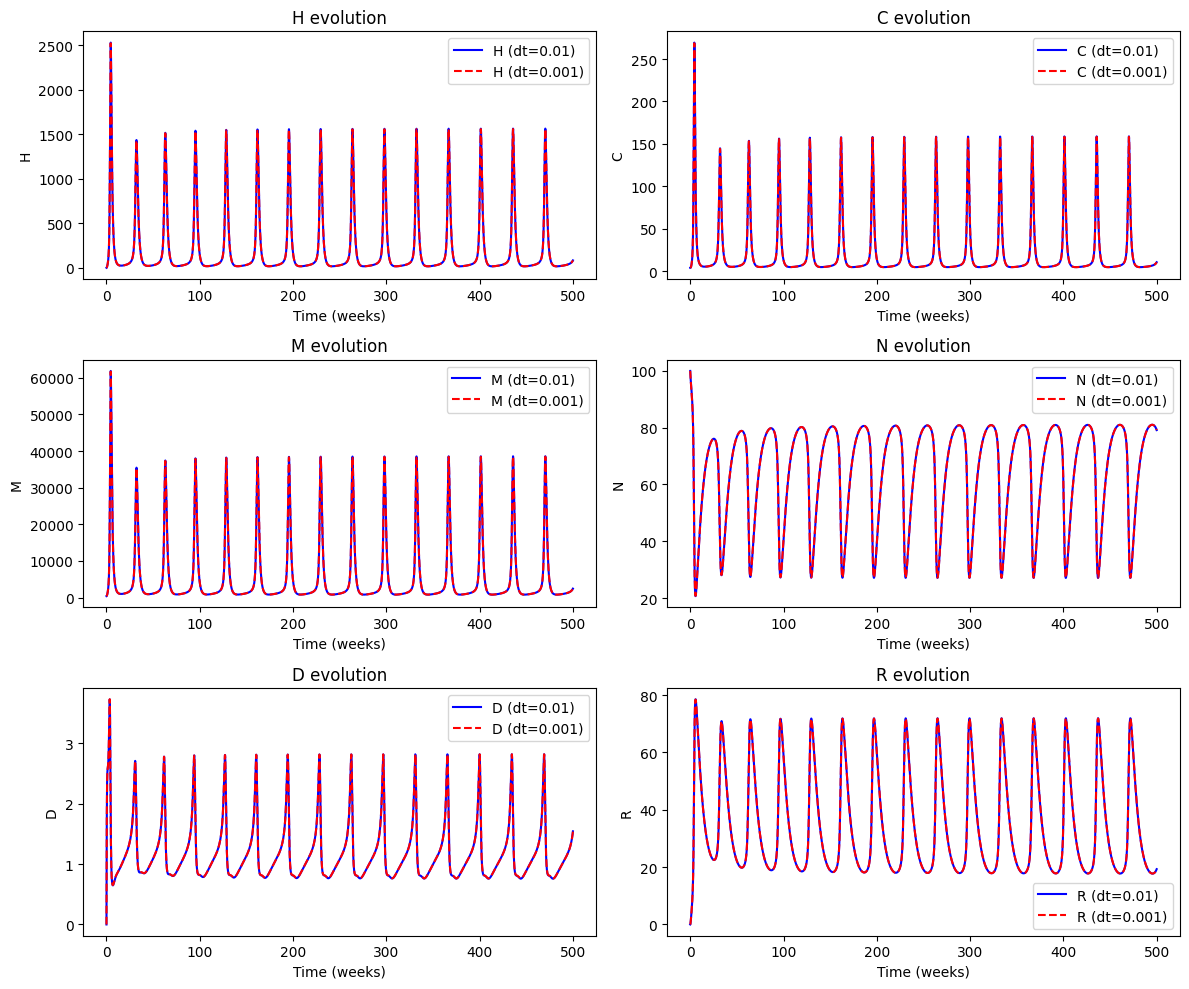

In [54]:
path_1 = f'prova/D_{diffusion[0]}/dt_0.01'
path_2 = f'prova/D_{diffusion[0]}/dt_0.001'
path_3 = f'prova/D_{diffusion[0]}/dt_0.0001'

filenames = ['H.csv', 'C.csv', 'M.csv', 'N.csv', 'D.csv', 'R.csv']
variable_names = ['H', 'C', 'M', 'N', 'D', 'R']

#Load data from the .csv files (dictionary comprehension)
data_1 = {var: pd.read_csv(os.path.join(path_1, f'{var}.csv')) for var in variable_names}
data_2 = {var: pd.read_csv(os.path.join(path_2, f'{var}.csv')) for var in variable_names}
#data_3 = {var: pd.read_csv(os.path.join(path_3, f'{var}.csv')) for var in variable_names}

#Since the simulations are computed with a different choice of dt,
#the larger time step dt=0.01 is used to create a common grid for interpolation
time_1 = data_1['H']['time'].values
common_time_grid = time_1

#six figures displayed in 3 rows with two columns on the same canvas
f, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.ravel()  #flatten the axes array for easy indexing

#Fill the figure with a plot for each state variable
for i, var in enumerate(variable_names):
#Extract data for the first simulation (dt=0.01)
    time_1 = data_1[var]['time'].values
    values_1 = data_1[var][f'value_{var}'].values

#Extract data for the second simulation (dt=0.001)
    time_2 = data_2[var]['time'].values
    values_2 = data_2[var][f'value_{var}'].values

#Extract data for the third simulation (dt=0.0001)
    time_3 = data_3[var]['time'].values
    values_3 = data_3[var][f'value_{var}'].values

#Interpolate the second and third simulation data to match the common time grid
    interpolator_2 = interp1d(time_2, values_2, kind='linear', fill_value='extrapolate')
    interpolated_values_2 = interpolator_2(common_time_grid)
    interpolator_3 = interp1d(time_3, values_3, kind='linear', fill_value='extrapolate')
    interpolated_values_3 = interpolator_3(common_time_grid)

#Plot the original and interpolated data
    axs[i].plot(time_1, values_1, label=f'{var} (dt=0.01)', color='blue')
    axs[i].plot(common_time_grid, interpolated_values_2, label=f'{var} (dt=0.001)', color='red', linestyle='--')
    axs[i].plot(common_time_grid, interpolated_values_3, label=f'{var} (dt=0.0001)', color='green', linestyle='dotted')

    axs[i].set_title(f'{var} evolution')
    axs[i].set_xlabel('Time (weeks)')
    axs[i].set_ylabel(f'{var}')
    axs[i].legend()

plt.tight_layout()
#plt.savefig(f'D_{diffusion[0]}_comparison_dt.png')

plt.show()